# Обработка видео
Классификация действий по видео


## Переключение версии TensorFlow

In [1]:
#%tensorflow_version 2.x

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [3]:
if 0:
    !pip install scikit-video==1.1.11
# import skvideo
# skvideo.setFFmpegPath(r'./ffmpeg-20190512-1cc7e26-win64-static/bin')
import skvideo.io

## Подготовка датасета для классификации

In [4]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

data_list = []
data_root = 'G:/data/KTH/'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        data_list.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [5]:
SUBSET_LEN = 100 # Количество пар для обучения
MAX_FRAMES = 300
BATCH_SIZE = 3
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001

In [6]:
class CreatingDataset():

  """Клас создания датасета"""

  def __init__(self,data_list=data_list, MAX_FRAMES=MAX_FRAMES, SUBSET_LEN=SUBSET_LEN, BATCH_SIZE=BATCH_SIZE, NUM_EPOCHS=NUM_EPOCHS):        
      self.data_list = data_list 
      self.MAX_FRAMES = MAX_FRAMES
      self.SUBSET_LEN = SUBSET_LEN
      self.BATCH_SIZE = BATCH_SIZE
      self.NUM_EPOCHS = NUM_EPOCHS

  def split_dataset(self, data_list, SUBSET_LEN):
    """Создание пар для обучения и разделение датасета на тестовый и тренировачный"""
    random.shuffle(data_list)
    data_array = np.array(data_list)
    train_x, valid_x, train_y, valid_y = train_test_split(data_array[:, 0],
                                                          data_array[:, 1],
                                                          train_size=SUBSET_LEN, random_state=21,
                                                          stratify=data_array[:, 1])

    assert SUBSET_LEN == len(train_x)

    dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
    test_dataset = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

    return dataset, test_dataset

  def dataset_processing(self, dataset, SUBSET_LEN, BATCH_SIZE):
    """обработка датасета"""



    def fpath_to_video(fpath):
        fpath = fpath.numpy().decode('utf-8')
        videodata = skvideo.io.vread(fpath)
        videodata = videodata.astype(np.float32) / 255.

        tmp = videodata.copy()
        # если количество кадров в видео меньше максимального
        if videodata.shape[0] < MAX_FRAMES:
          # то определяем сколко раз надо повторить операцию vstack
          num_iter = round(MAX_FRAMES / videodata.shape[0]) + 1
          # создаем временный файл, в котором будем хранить повторы
          tmp = videodata.copy()
          # стакаем необходимое количество раз
          for iterations in range(num_iter):
            tmp = np.vstack((tmp, videodata))
            if tmp.shape[0] > MAX_FRAMES:
              break
          # так как мы повторяли ролик сам в себя несколько раз, то его длина может быть больше чем необходимая
          # поэтому возьмем только необходимое нам количество кадров
        tmp = tmp[:MAX_FRAMES, ...]
        
        return tmp

    dataset = dataset.map(lambda fpath, label: (tf.py_function(fpath_to_video, [fpath], Tout=tf.float32),
                                                tf.numpy_function(np.int8, [label], tf.int8)))
    dataset = dataset.shuffle(buffer_size=SUBSET_LEN)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

  def bilder_dataset(self,data_list=data_list, MAX_FRAMES=MAX_FRAMES, SUBSET_LEN=SUBSET_LEN, BATCH_SIZE=BATCH_SIZE, NUM_EPOCHS=NUM_EPOCHS):
    """Сборка доатасета"""
    dataset, test_dataset = self.split_dataset(data_list, SUBSET_LEN)
    dataset = self.dataset_processing(dataset, SUBSET_LEN, BATCH_SIZE)
    test_dataset = self.dataset_processing(test_dataset, SUBSET_LEN, BATCH_SIZE)

    return dataset, test_dataset



In [7]:
CD = CreatingDataset()
dataset, test_dataset = CD.bilder_dataset(data_list, MAX_FRAMES, SUBSET_LEN, BATCH_SIZE, NUM_EPOCHS)

## Создание модели CNN

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

## Подготовка к обучению

In [9]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

## Цикл обучения модели

In [10]:
%%time
global_step = 0
losses = []
for ep in range(NUM_EPOCHS):
    for i, (videodata, labels) in enumerate(dataset):
        loss_value = model.train_on_batch(videodata, labels)

        if i % 10 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{i}/{SUBSET_LEN}] Loss: {loss_value}')
            losses.append([loss_value, global_step])
               
        global_step += 1

[0/10][0/100] Loss: 1.7936149835586548
[0/10][10/100] Loss: 1.7732490301132202
[0/10][20/100] Loss: 1.748522400856018
[0/10][30/100] Loss: 1.809068202972412
[1/10][0/100] Loss: 1.790202021598816
[1/10][10/100] Loss: 1.7841545343399048
[1/10][20/100] Loss: 1.785788893699646
[1/10][30/100] Loss: 1.7989693880081177
[2/10][0/100] Loss: 1.7946783304214478
[2/10][10/100] Loss: 1.7858113050460815
[2/10][20/100] Loss: 1.7936553955078125
[2/10][30/100] Loss: 1.7856248617172241
[3/10][0/100] Loss: 1.7857780456542969
[3/10][10/100] Loss: 1.713941216468811
[3/10][20/100] Loss: 1.882381796836853
[3/10][30/100] Loss: 1.8041529655456543
[4/10][0/100] Loss: 1.786392092704773
[4/10][10/100] Loss: 1.7860034704208374
[4/10][20/100] Loss: 1.7840633392333984
[4/10][30/100] Loss: 1.9123591184616089
[5/10][0/100] Loss: 1.7901116609573364
[5/10][10/100] Loss: 1.7567726373672485
[5/10][20/100] Loss: 1.782395362854004
[5/10][30/100] Loss: 1.7742735147476196
[6/10][0/100] Loss: 1.7888683080673218
[6/10][10/100] 

## Loss

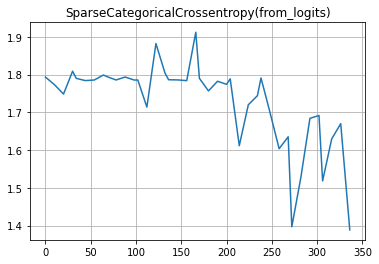

In [13]:
losses_array = np.array(losses)
plt.plot(losses_array[:, 1], losses_array[:, 0])
plt.title('SparseCategoricalCrossentropy(from_logits)')
plt.grid(True)
plt.show()